# Measurement Set Tutorial

This tutorial notebook can be run on the Google Colaboratory environment via this [link](https://colab.research.google.com/github/casangi/xradio/blob/main/docs/source/measurement_set/tutorials/measurement_set_tutorial.ipynb).

**XRADIO** is an open-source Python package that leverages [xarray](https://github.com/pydata/xarray) to provide an interface for radio astronomy data. It includes converters for legacy formats and defines versioned schemas for each dataset type. A schema checker is also included to verify whether a dataset conforms to the expected schema.

Data is organized into the following structures:

- [`xarray.Dataset`](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html): A multi-dimensional, in-memory array container for labeled n-dimensional arrays.
- [`xarray.DataArray`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html): An n-dimensional array with labeled coordinates and dimensions.
- [`xarray.DataTree`](https://docs.xarray.dev/en/latest/generated/xarray.DataTree.html): A tree-like hierarchical collection of xarray objects (datasets and children trees).

XRADIO extends the functionality of these xarray data structures by making use of **xarray accessors**.

To use XRADIO effectively, it's important to understand the terminology and indexing methods used in xarray. The following documentation is recommended reading:

- [xarray terminology](https://docs.xarray.dev/en/latest/user-guide/terminology.html)
- [xarray data structures](https://docs.xarray.dev/en/latest/user-guide/data-structures.html) (arrays, coordinates, datasets, and data trees)
- [xarray indexing and selection guide](https://docs.xarray.dev/en/latest/user-guide/indexing.html)
- [xarray accessors](https://docs.xarray.dev/en/latest/internals/extending-xarray.html)

## Acronyms Used

- `ps` = processing set  
- `ms` = measurement set  
- `cor` = correlated  
- `xdt` = xarray DataTree  
- `xds` = xarray Dataset  
- `xda` = xarray DataArray  

Using these acronyms one can refer for example to the Processing Set DataTree (`ps_xdt`), the Measurement Set DataTree (`ms_xdt`) or the correlated dataset (`cor_xds`).

## Measurement Set v4 Schema Layout

The Measurement Set v4 (MSv4) schema for radio telescope interferometric data (*Visibilities*) and single-dish data (*Spectrum*) is implemented in memory as an [`xarray.DataTree`](https://docs.xarray.dev/en/latest/generated/xarray.DataTree.html). 

The root node of this data tree (the measurement set `xarray.DataTree`, `ms_xdt`), is the `cor_xds` (correlated `xarray.Dataset`), which contains the Visibility or Spectrum data. It also includes data that shares the same dimensions as the Visibility/Spectrum data and serves a similar role to the *Main* table in Measurement Set v2 (MSv2).

The child nodes of `ms_xdt` contain metadata such as antenna positions, field and source definitions, and other auxiliary information. Each `ms_xdt` is limited to a single observation, spectral window, polarization setup, observation mode, processor, and beam per antenna.

Multiple `ms_xdt` trees can be grouped together as children of a processing set data tree (`ps_xdt`). This tree has an empty root node, with each child node representing an individual `ms_xdt`. The design of `ps_xdt` is inspired by the [Multi-MS format](https://casadocs.readthedocs.io/en/v6.2.0/notebooks/parallel-processing.html#The-Multi-MS) in MSv2.

Figure 1 illustrates a simplified comparison between the Processing Set structure in MSv4 and the Multi-MS structure in MSv2. Blocks with the same color indicate similar information content. Blocks in between parenthesis are optional in their respective schemas.

<div style="text-align: center;">
    <figure id="figure-1" style="display: inline-block;">
        <img src="https://docs.google.com/drawings/d/e/2PACX-1vSLr1lkfL2G5-1ecS1TCK8mblAq-MSj-RVuVYBFse9FhmuZakIBKfUcXSBJzzmarSGWeNcKFVaEJ8M5/pub?w=1242&amp;h=525"
             alt="fig1_ps_vs_mms"
             style="display: block; margin: auto;">
        <figcaption>Figure 1: Schema layouts of the Processing Set (collection of MSv4s) and the 
            <a href="https://casadocs.readthedocs.io/en/stable/notebooks/parallel-processing.html#The-Multi-MS" target="_blank">Multi Measurement Set (MSv2).</a>
        </figcaption>
    </figure>
</div>
<!-- source https://docs.google.com/drawings/d/11hcEuE21xLAm6L8echf-Vu-7rfHZAaEzBFWQHCjOdSs/edit -->


### Access Pattern Cheat Sheet

```python
import xarray as xr
import xradio  # Enables accessors
from xradio.measurement_set import open_processing_set

# Open a processing set data tree
ps_xdt = open_processing_set("my_ps.ps.zarr")  # or xr.open_datatree("...")

# Access an individual Measurement Set data tree of the processing set
msv4_name = "my_msv4"
ms_xdt = ps_xdt[msv4_name]

# Access the correlated dataset and antenna dataset
cor_xds = ms_xdt.ds
antenna_xds = ms_xdt.antenna_xds.ds
```

Available accessors:
- ps_xdt.xr_ps (as processing set accessor)
    - summary # returns a data frame 
    - get_max_dims
    - get_freq_axis
    - sel #based on summary data frame
    - get_combined_field_and_source_xds
    - plot_phase_centers 
    - get_combined_antenna_xds
    - plot_antenna_positions 
    - ...
- ms_xdt.xr_ms (as measurement set accesor)
    - sel #allows for data group selection
    - get_field_and_source_xds
    - get_partition_info


All these accessors will be used during the tutorial.



## Preparation

### Import XRADIO

In [1]:
from importlib.metadata import version
import os

try:
    os.system("pip install --upgrade xradio")

    import xradio

    print("Using xradio version", version("xradio"))

except ImportError as exc:
    print(f"Could not import xradio: {exc}")

Using xradio version 0.0.58


### Download example MSv2

In [2]:
import toolviper

toolviper.utils.data.download(file="Antennae_North.cal.lsrk.split.ms")

[2025-09-09 18:43:21,445]     INFO    viperlog:  Downloading from [cloudflare] .... 


 Download List                     
 ────────────────────────────────── 
  Antennae_North.cal.lsrk.split.ms

Output()

## Processing Set

### Convert MSv2 to Processing Set Xarray Data Tree (ps_xdt)

Before running the conversion function we can get an estimate of the resources that will be needed:

In [3]:
from xradio.measurement_set import estimate_conversion_memory_and_cores

msv2_name = "Antennae_North.cal.lsrk.split.ms"
mem_estimate, max_reasonable_cores, suggested_cores = estimate_conversion_memory_and_cores(msv2_name)
mem_estimate, max_reasonable_cores, suggested_cores

[2025-09-09 18:43:23,839]     INFO    viperlog:  Partition scheme that will be used: ['DATA_DESC_ID', 'OBS_MODE', 'OBSERVATION_ID', 'FIELD_ID'] 


(0.010186754912137986, 12, 3)

The function used to estimate resources gives:
- an estimate of memory required in GiB,
- a maximum "reasonable" number of cores to use when converting in parallel, which is the number of partitions or MSv4s in the output processing set,
- and a suggested number of cores to use, as a rule of thumb the maximum / 4.

If we want to run the conversion in parallel, using Dask, we can initialize a "VIPER" client. In this example we use a local Dask client with the suggested number of cores = Dask workers:

In [4]:
do_parallel = True
if do_parallel:
    from toolviper import dask
    viper_client = toolviper.dask.local_client(cores=suggested_cores)

[2025-09-09 18:43:24,176]     INFO    viperlog:  Module path: /home/fedemp/ws_xradio_dev/venv_xradio_python313/lib/python3.13/site-packages/toolviper 
[2025-09-09 18:43:24,192]  WARNING    viperlog:  It is recommended that the local cache directory be set using the dask_local_dir parameter. 
[2025-09-09 18:43:25,076]     INFO    viperlog:  Client <MenrvaClient: 'tcp://127.0.0.1:42373' processes=3 threads=3, memory=5.84 GiB> 


Convert the example MeasurementSet v2 to Processing Set:

In [5]:
from xradio.measurement_set import convert_msv2_to_processing_set

convert_out = "Antennae_North.cal.lsrk.split.ps.zarr"
convert_msv2_to_processing_set(
    in_file=msv2_name,
    out_file=convert_out,
    overwrite=True,
    parallel_mode=do_parallel,
)

[2025-09-09 18:43:25,118]  WARNING    viperlog:  `parallel_mode` True not recognosed. Defauling to 'none'. 
[2025-09-09 18:43:25,130]     INFO    viperlog:  Partition scheme that will be used: ['DATA_DESC_ID', 'OBS_MODE', 'OBSERVATION_ID', 'FIELD_ID'] 
[2025-09-09 18:43:25,245]     INFO    viperlog:  Number of partitions: 12 
[2025-09-09 18:43:25,247]     INFO    viperlog:  OBSERVATION_ID [0], DDI [0], STATE [32 23 30 37], FIELD [0], SCAN [ 9 17 21 25] 
[2025-09-09 18:43:25,514]     INFO    viperlog:  OBSERVATION_ID [0], DDI [0], STATE [33 24 31], FIELD [1], SCAN [ 9 17 21] 
[2025-09-09 18:43:25,720]     INFO    viperlog:  OBSERVATION_ID [0], DDI [0], STATE [34 25 32], FIELD [2], SCAN [ 9 17 21] 
[2025-09-09 18:43:25,915]     INFO    viperlog:  OBSERVATION_ID [1], DDI [0], STATE [32 23 30 37], FIELD [0], SCAN [26 34 38 42] 
[2025-09-09 18:43:26,151]     INFO    viperlog:  OBSERVATION_ID [1], DDI [0], STATE [33 24 31], FIELD [1], SCAN [26 34 38] 
[2025-09-09 18:43:26,328]     INFO    vi

### Processing Set Xarray Data Tree (ps_xdt)

A `ps_xdt` (Processing Set DataTree) can be lazily opened using either [`xradio.measurement_set.open_processing_set`](https://casangi.github.io/xradio/api/xradio.measurement_set.html#xradio.measurement_set.open_processing_set) or [`xarray.open_datatree`](https://docs.xarray.dev/en/latest/generated/xarray.open_datatree.html). When lazily opened, none of the data variables within the datasets are immediately loaded into memory. Instead, they are represented by lazy Dask arrays. The `open_processing_set` function provided by `xradio.measurement_set` exists to support future storage formats that are not natively handled by xarray. For example, telescopes such as ALMA and the VLA produce data in the ASDM (Astronomical Science Data Model) format, which may require custom loading and conversion logic. By using `open_processing_set`, XRADIO ensures flexibility and extensibility for supporting complex and evolving data formats beyond the scope of standard xarray I/O. "Antennae_North.cal.lsrk.split.ps.zarr" consists of 12 `ms_xdt` which can be seen by clicking on the Groups dropdown arrow.

In [6]:
from xradio.measurement_set import open_processing_set
convert_out = "Antennae_North.cal.lsrk.split.ps.zarr"

ps_xdt = open_processing_set(convert_out)
ps_xdt

<xarray.DataTree>
Group: /
│   Attributes:
│       type:     processing_set
├── Group: /Antennae_North.cal.lsrk.split_00
│   │   Dimensions:                     (time: 20, baseline_id: 45, frequency: 8,
│   │                                    polarization: 2, uvw_label: 3)
│   │   Coordinates:
│   │       baseline_antenna1_name      (baseline_id) <U9 2kB ...
│   │       baseline_antenna2_name      (baseline_id) <U9 2kB ...
│   │     * baseline_id                 (baseline_id) int64 360B 0 1 2 3 ... 41 42 43 44
│   │       field_name                  (time) <U46 4kB ...
│   │     * frequency                   (frequency) float64 64B 3.439e+11 ... 3.44e+11
│   │     * polarization                (polarization) <U2 16B 'XX' 'YY'
│   │       scan_name                   (time) <U21 2kB ...
│   │     * time                        (time) float64 160B 1.307e+09 ... 1.307e+09
│   │     * uvw_label                   (uvw_label) <U1 12B 'u' 'v' 'w'
│   │   Data variables:
│   │       EFFECTIVE_INTEGRATION_TIME  (time, baseline_id) float64 7kB ...
│   │       FLAG                        (time, baseline_id, frequency, polarization) bool 14kB ...
│   │       TIME_CENTROID               (time, baseline_id) float64 7kB ...
│   │       UVW                         (time, baseline_id, uvw_label) float64 22kB ...
│   │       VISIBILITY                  (time, baseline_id, frequency, polarization) complex64 115kB ...
│   │       WEIGHT                      (time, baseline_id, frequency, polarization) float32 58kB ...
│   │   Attributes:
│   │       creation_date:     2025-09-09T16:43:25.293841+00:00
│   │       creator:           {'software_name': 'xradio', 'version': '0.0.58'}
│   │       data_groups:       {'base': {'correlated_data': 'VISIBILITY', 'date': '20...
│   │       observation_info:  {'intents': ['OBSERVE_TARGET#ON_SOURCE'], 'observer': ...
│   │       processor_info:    {'sub_type': 'ALMA_CORRELATOR_MODE', 'type': 'CORRELAT...
│   │       schema_version:    4.0.-9988
│   │       type:              visibility
│   ├── Group: /Antennae_North.cal.lsrk.split_00/antenna_xds
│   │       Dimensions:                 (antenna_name: 10, cartesian_pos_label: 3,
│   │                                    receptor_label: 2)
│   │       Coordinates:
│   │         * antenna_name            (antenna_name) <U9 360B 'DV02_A015' ... 'PM03_J504'
│   │         * cartesian_pos_label     (cartesian_pos_label) <U1 12B 'x' 'y' 'z'
│   │           mount                   (antenna_name) <U6 240B ...
│   │           polarization_type       (antenna_name, receptor_label) <U1 80B ...
│   │         * receptor_label          (receptor_label) <U5 40B 'pol_0' 'pol_1'
│   │           station_name            (antenna_name) <U4 160B ...
│   │           telescope_name          (antenna_name) <U4 160B ...
│   │       Data variables:
│   │           ANTENNA_DISH_DIAMETER   (antenna_name) float64 80B ...
│   │           ANTENNA_POSITION        (antenna_name, cartesian_pos_label) float64 240B ...
│   │           ANTENNA_RECEPTOR_ANGLE  (antenna_name, receptor_label) float64 160B ...
│   │       Attributes:
│   │           overall_telescope_name:  ALMA
│   │           relocatable_antennas:    True
│   │           type:                    antenna
│   ├── Group: /Antennae_North.cal.lsrk.split_00/field_and_source_base_xds
│   │       Dimensions:                       (field_name: 1, sky_dir_label: 2)
│   │       Coordinates:
│   │         * field_name                    (field_name) <U46 184B 'NGC4038 - Antennae ...
│   │         * sky_dir_label                 (sky_dir_label) <U3 24B 'ra' 'dec'
│   │           source_name                   (field_name) <U46 184B ...
│   │       Data variables:
│   │           FIELD_PHASE_CENTER_DIRECTION  (field_name, sky_dir_label) float64 16B ...
│   │           SOURCE_DIRECTION              (field_name, sky_dir_label) float64 16B ...
│   │       Attributes:
│   │           type:     field_and_source
│   └── Group: /Antennae_North.cal.lsrk.split

In [7]:
import xarray

ps_xdt = xarray.open_datatree(convert_out)
ps_xdt

<xarray.DataTree>
Group: /
│   Attributes:
│       type:     processing_set
├── Group: /Antennae_North.cal.lsrk.split_00
│   │   Dimensions:                     (time: 20, baseline_id: 45, frequency: 8,
│   │                                    polarization: 2, uvw_label: 3)
│   │   Coordinates:
│   │       baseline_antenna1_name      (baseline_id) <U9 2kB ...
│   │       baseline_antenna2_name      (baseline_id) <U9 2kB ...
│   │     * baseline_id                 (baseline_id) int64 360B 0 1 2 3 ... 41 42 43 44
│   │       field_name                  (time) <U46 4kB ...
│   │     * frequency                   (frequency) float64 64B 3.439e+11 ... 3.44e+11
│   │     * polarization                (polarization) <U2 16B 'XX' 'YY'
│   │       scan_name                   (time) <U21 2kB ...
│   │     * time                        (time) float64 160B 1.307e+09 ... 1.307e+09
│   │     * uvw_label                   (uvw_label) <U1 12B 'u' 'v' 'w'
│   │   Data variables:
│   │       EFFECTIVE_INTEGRATION_TIME  (time, baseline_id) float64 7kB ...
│   │       FLAG                        (time, baseline_id, frequency, polarization) bool 14kB ...
│   │       TIME_CENTROID               (time, baseline_id) float64 7kB ...
│   │       UVW                         (time, baseline_id, uvw_label) float64 22kB ...
│   │       VISIBILITY                  (time, baseline_id, frequency, polarization) complex64 115kB ...
│   │       WEIGHT                      (time, baseline_id, frequency, polarization) float32 58kB ...
│   │   Attributes:
│   │       creation_date:     2025-09-09T16:43:25.293841+00:00
│   │       creator:           {'software_name': 'xradio', 'version': '0.0.58'}
│   │       data_groups:       {'base': {'correlated_data': 'VISIBILITY', 'date': '20...
│   │       observation_info:  {'intents': ['OBSERVE_TARGET#ON_SOURCE'], 'observer': ...
│   │       processor_info:    {'sub_type': 'ALMA_CORRELATOR_MODE', 'type': 'CORRELAT...
│   │       schema_version:    4.0.-9988
│   │       type:              visibility
│   ├── Group: /Antennae_North.cal.lsrk.split_00/antenna_xds
│   │       Dimensions:                 (antenna_name: 10, cartesian_pos_label: 3,
│   │                                    receptor_label: 2)
│   │       Coordinates:
│   │         * antenna_name            (antenna_name) <U9 360B 'DV02_A015' ... 'PM03_J504'
│   │         * cartesian_pos_label     (cartesian_pos_label) <U1 12B 'x' 'y' 'z'
│   │           mount                   (antenna_name) <U6 240B ...
│   │           polarization_type       (antenna_name, receptor_label) <U1 80B ...
│   │         * receptor_label          (receptor_label) <U5 40B 'pol_0' 'pol_1'
│   │           station_name            (antenna_name) <U4 160B ...
│   │           telescope_name          (antenna_name) <U4 160B ...
│   │       Data variables:
│   │           ANTENNA_DISH_DIAMETER   (antenna_name) float64 80B ...
│   │           ANTENNA_POSITION        (antenna_name, cartesian_pos_label) float64 240B ...
│   │           ANTENNA_RECEPTOR_ANGLE  (antenna_name, receptor_label) float64 160B ...
│   │       Attributes:
│   │           overall_telescope_name:  ALMA
│   │           relocatable_antennas:    True
│   │           type:                    antenna
│   ├── Group: /Antennae_North.cal.lsrk.split_00/field_and_source_base_xds
│   │       Dimensions:                       (field_name: 1, sky_dir_label: 2)
│   │       Coordinates:
│   │         * field_name                    (field_name) <U46 184B 'NGC4038 - Antennae ...
│   │         * sky_dir_label                 (sky_dir_label) <U3 24B 'ra' 'dec'
│   │           source_name                   (field_name) <U46 184B ...
│   │       Data variables:
│   │           FIELD_PHASE_CENTER_DIRECTION  (field_name, sky_dir_label) float64 16B ...
│   │           SOURCE_DIRECTION              (field_name, sky_dir_label) float64 16B ...
│   │       Attributes:
│   │           type:     field_and_source
│   └── Group: /Antennae_North.cal.lsrk.split

#### Processing Set Xarray Data Tree (ps_xdt) Accessors


- ps_xdt.xr_ps.
    - summary # returns a data frame 
    - get_max_dims
    - get_freq_axis
    - query # based on summary data frame
    - get_combined_field_and_source_xds
    - plot_phase_centers 
    - get_combined_antenna_xds
    - plot_antenna_positions 
    - **Additional Accessors can be requested using a GitHub Issue**

Note: All accessors used in this tutorial are only available if `import xradio` has been called. This ensures the XRADIO-specific accessor methods are properly registered with xarray. 

For a convenient summary of the `ms_xdt`s within a `ps_xdt`, the `.summary()` function from the `xr_ps` accessor can be used. 

In [8]:
ps_xdt.xr_ps.summary()

,name,intents,shape,polarization,scan_name,spw_name,spw_intent,field_name,source_name,line_name,field_coords,start_frequency,end_frequency
0,Antennae_North.cal.lsrk.split_00,[OBSERVE_TARGET#ON_SOURCE],"(20, 45, 8, 2)","[XX, YY]","[17, 21, 25, 9]",spw_0,UNSPECIFIED,[NGC4038 - Antennae North_0],[NGC4038 - Antennae North_0],[],"[fk5, 12h01m52.43s, -18d52m02.92s]",3.439281e+11,3.440067e+11
1,Antennae_North.cal.lsrk.split_01,[OBSERVE_TARGET#ON_SOURCE],"(15, 45, 8, 2)","[XX, YY]","[17, 21, 9]",spw_0,UNSPECIFIED,[NGC4038 - Antennae North_1],[NGC4038 - Antennae North_0],[],"[fk5, 12h01m52.96s, -18d52m02.92s]",3.439281e+11,3.440067e+11
2,Antennae_North.cal.lsrk.split_02,[OBSERVE_TARGET#ON_SOURCE],"(15, 45, 8, 2)","[XX, YY]","[17, 21, 9]",spw_0,UNSPECIFIED,[NGC4038 - Antennae North_2],[NGC4038 - Antennae North_0],[],"[fk5, 12h01m53.49s, -18d52m02.92s]",3.439281e+11,3.440067e+11
3,Antennae_North.cal.lsrk.split_03,[OBSERVE_TARGET#ON_SOURCE],"(20, 55, 8, 2)","[XX, YY]","[26, 34, 38, 42]",spw_0,UNSPECIFIED,[NGC4038 - Antennae North_0],[NGC4038 - Antennae North_0],[],"[fk5, 12h01m52.43s, -18d52m02.92s]",3.439281e+11,3.440067e+11
4,Antennae_North.cal.lsrk.split_04,[OBSERVE_TARGET#ON_SOURCE],"(15, 55, 8, 2)","[XX, YY]","[26, 34, 38]",spw_0,UNSPECIFIED,[NGC4038 - Antennae North_1],[NGC4038 - Antennae North_0],[],"[fk5, 12h01m52.96s, -18d52m02.92s]",3.439281e+11,3.440067e+11
5,Antennae_North.cal.lsrk.split_05,[OBSERVE_TARGET#ON_SOURCE],"(15, 55, 8, 2)","[XX, YY]","[26, 34, 38]",spw_0,UNSPECIFIED,[NGC4038 - Antennae North_2],[NGC4038 - Antennae North_0],[],"[fk5, 12h01m53.49s, -18d52m02.92s]",3.439281e+11,3.440067e+11
6,Antennae_North.cal.lsrk.split_06,[OBSERVE_TARGET#ON_SOURCE],"(5, 55, 8, 2)","[XX, YY]",[43],spw_0,UNSPECIFIED,[NGC4038 - Antennae North_0],[NGC4038 - Antennae North_0],[],"[fk5, 12h01m52.43s, -18d52m02.92s]",3.439281e+11,3.440067e+11
7,Antennae_North.cal.lsrk.split_07,[OBSERVE_TARGET#ON_SOURCE],"(5, 55, 8, 2)","[XX, YY]",[43],spw_0,UNSPECIFIED,[NGC4038 - Antennae North_1],[NGC4038 - Antennae North_0],[],"[fk5, 12h01m52.96s, -18d52m02.92s]",3.439281e+11,3.440067e+11
8,Antennae_North.cal.lsrk.split_08,[OBSERVE_TARGET#ON_SOURCE],"(5, 55, 8, 2)","[XX, YY]",[43],spw_0,UNSPECIFIED,[NGC4038 - Antennae North_2],[NGC4038 - Antennae North_0],[],"[fk5, 12h01m53.49s, -18d52m02.92s]",3.439281e+11,3.440067e+11
9,Antennae_North.cal.lsrk.split_09,"[OBSERVE_TARGET#ON_SOURCE, CALIBRATE_WVR#ON_SO...","(20, 77, 8, 2)","[XX, YY]","[48, 56, 60, 64]",spw_0,UNSPECIFIED,[NGC4038 - Antennae North_0],[NGC4038 - Antennae North_0],[],"[fk5, 12h01m52.43s, -18d52m02.92s]",3.439281e+11,3.440067e+11


In [9]:
ps_xdt.xr_ps.get_max_dims()

{'time': 20,
 'baseline_id': 77,
 'frequency': 8,
 'polarization': 2,
 'uvw_label': 3}

In [10]:
ps_xdt.xr_ps.get_freq_axis()

<xarray.DataArray 'frequency' (frequency: 8)> Size: 64B
array([3.439281e+11, 3.439393e+11, 3.439506e+11, 3.439618e+11, 3.439730e+11,
       3.439843e+11, 3.439955e+11, 3.440067e+11])
Coordinates:
  * frequency  (frequency) float64 64B 3.439e+11 3.439e+11 ... 3.44e+11 3.44e+11
Attributes:
    channel_width:           {'attrs': {'type': 'quantity', 'units': 'Hz'}, '...
    observer:                lsrk
    reference_frequency:     {'attrs': {'observer': 'lsrk', 'type': 'spectral...
    spectral_window_intent:  UNSPECIFIED
    spectral_window_name:    spw_0
    type:                    spectral_coord
    units:                   Hz

In [11]:

sub_ps_xdt = ps_xdt.xr_ps.query(
    field_name=["NGC4038 - Antennae North_0", "NGC4038 - Antennae North_1"],
    scan_name = ["17"]
)
sub_ps_xdt.xr_ps.summary()


,name,intents,shape,polarization,scan_name,spw_name,spw_intent,field_name,source_name,line_name,field_coords,start_frequency,end_frequency
0,Antennae_North.cal.lsrk.split_00,[OBSERVE_TARGET#ON_SOURCE],"(20, 45, 8, 2)","[XX, YY]","[17, 21, 25, 9]",spw_0,UNSPECIFIED,[NGC4038 - Antennae North_0],[NGC4038 - Antennae North_0],[],"[fk5, 12h01m52.43s, -18d52m02.92s]",3.439281e+11,3.440067e+11
1,Antennae_North.cal.lsrk.split_01,[OBSERVE_TARGET#ON_SOURCE],"(15, 45, 8, 2)","[XX, YY]","[17, 21, 9]",spw_0,UNSPECIFIED,[NGC4038 - Antennae North_1],[NGC4038 - Antennae North_0],[],"[fk5, 12h01m52.96s, -18d52m02.92s]",3.439281e+11,3.440067e+11


In [12]:
ps_xdt.xr_ps.query().xr_ps.get_combined_field_and_source_xds()

<xarray.Dataset> Size: 3kB
Dimensions:                       (field_name: 3, sky_dir_label: 2,
                                   baseline_id: 77, frequency: 8,
                                   polarization: 2, time: 165, uvw_label: 3)
Coordinates:
  * baseline_id                   (baseline_id) int64 616B 0 1 2 3 ... 74 75 76
  * frequency                     (frequency) float64 64B 3.439e+11 ... 3.44e+11
  * polarization                  (polarization) <U2 16B 'XX' 'YY'
  * time                          (time) float64 1kB 1.307e+09 ... 1.308e+09
  * uvw_label                     (uvw_label) <U1 12B 'u' 'v' 'w'
  * sky_dir_label                 (sky_dir_label) <U3 24B 'ra' 'dec'
  * field_name                    (field_name) <U46 552B 'NGC4038 - Antennae ...
    source_name                   (field_name) <U46 552B 'NGC4038 - Antennae ...
Data variables:
    FIELD_PHASE_CENTER_DIRECTION  (field_name, sky_dir_label) float64 48B 3.1...
    SOURCE_DIRECTION              (field_name, sky_dir_label) float64 48B 3.1...
    MEAN_PHASE_CENTER_DIRECTION   (sky_dir_label) float64 16B 3.15 -0.3293
Attributes:
    type:               field_and_source
    center_field_name:  NGC4038 - Antennae North_1

In [13]:
ps_xdt.xr_ps.query(intents="OBSERVE_TARGET#ON_SOURCE").xr_ps.get_combined_field_and_source_xds()

<xarray.Dataset> Size: 3kB
Dimensions:                       (field_name: 3, sky_dir_label: 2,
                                   baseline_id: 77, frequency: 8,
                                   polarization: 2, time: 165, uvw_label: 3)
Coordinates:
  * baseline_id                   (baseline_id) int64 616B 0 1 2 3 ... 74 75 76
  * frequency                     (frequency) float64 64B 3.439e+11 ... 3.44e+11
  * polarization                  (polarization) <U2 16B 'XX' 'YY'
  * time                          (time) float64 1kB 1.307e+09 ... 1.308e+09
  * uvw_label                     (uvw_label) <U1 12B 'u' 'v' 'w'
  * sky_dir_label                 (sky_dir_label) <U3 24B 'ra' 'dec'
  * field_name                    (field_name) <U46 552B 'NGC4038 - Antennae ...
    source_name                   (field_name) <U46 552B 'NGC4038 - Antennae ...
Data variables:
    FIELD_PHASE_CENTER_DIRECTION  (field_name, sky_dir_label) float64 48B 3.1...
    SOURCE_DIRECTION              (field_name, sky_dir_label) float64 48B 3.1...
    MEAN_PHASE_CENTER_DIRECTION   (sky_dir_label) float64 16B 3.15 -0.3293
Attributes:
    type:               field_and_source
    center_field_name:  NGC4038 - Antennae North_1

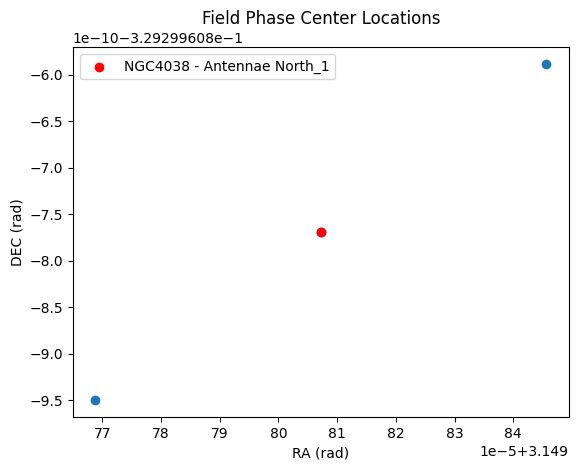

In [14]:
ps_xdt.xr_ps.query(intents="OBSERVE_TARGET#ON_SOURCE").xr_ps.plot_phase_centers()

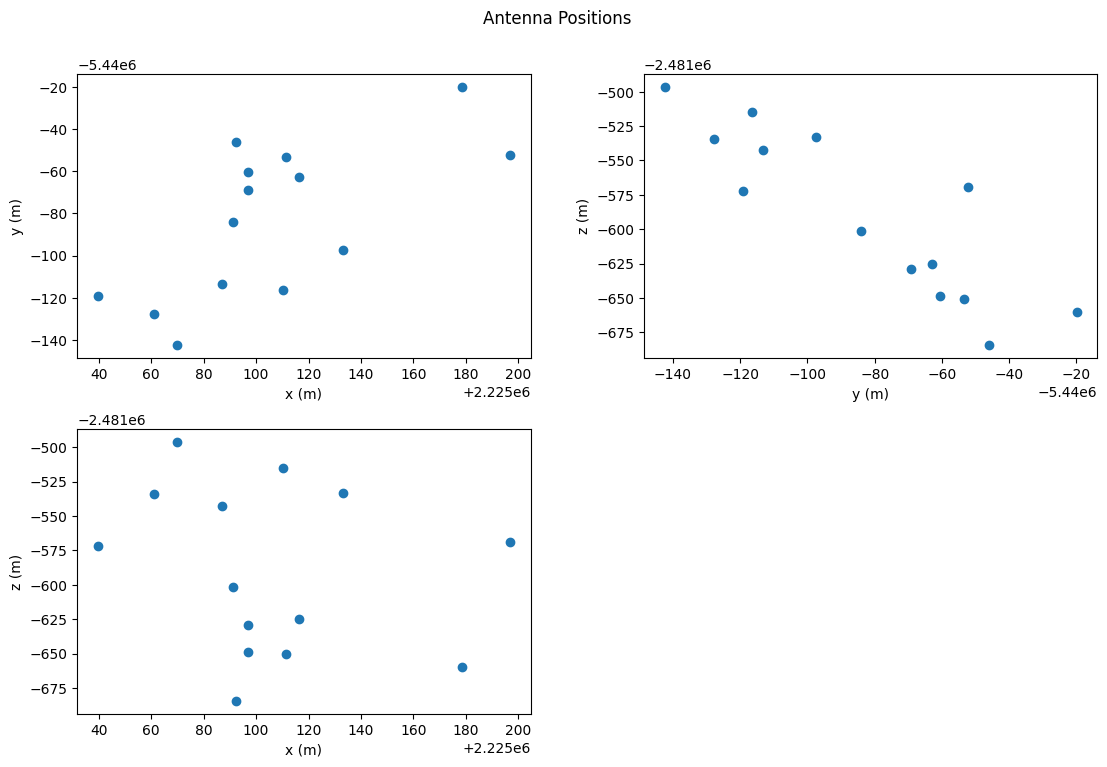

In [15]:
ps_xdt.xr_ps.plot_antenna_positions()

### Measurement Set Data Tree (ms_xdt)

An individual ms_xdt can be accessed by using name (`xr_ps.summary()` name column) as a dictionary key:

In [16]:
ms_xdt = ps_xdt[
    "Antennae_North.cal.lsrk.split_00"
]
ms_xdt

<xarray.DataTree 'Antennae_North.cal.lsrk.split_00'>
Group: /Antennae_North.cal.lsrk.split_00
│   Dimensions:                     (time: 20, baseline_id: 45, frequency: 8,
│                                    polarization: 2, uvw_label: 3)
│   Coordinates:
│       baseline_antenna1_name      (baseline_id) <U9 2kB ...
│       baseline_antenna2_name      (baseline_id) <U9 2kB ...
│     * baseline_id                 (baseline_id) int64 360B 0 1 2 3 ... 41 42 43 44
│       field_name                  (time) <U46 4kB ...
│     * frequency                   (frequency) float64 64B 3.439e+11 ... 3.44e+11
│     * polarization                (polarization) <U2 16B 'XX' 'YY'
│       scan_name                   (time) <U21 2kB '9' '9' '9' ... '25' '25' '25'
│     * time                        (time) float64 160B 1.307e+09 ... 1.307e+09
│     * uvw_label                   (uvw_label) <U1 12B 'u' 'v' 'w'
│   Data variables:
│       EFFECTIVE_INTEGRATION_TIME  (time, baseline_id) float64 7kB ...
│       FLAG                        (time, baseline_id, frequency, polarization) bool 14kB ...
│       TIME_CENTROID               (time, baseline_id) float64 7kB ...
│       UVW                         (time, baseline_id, uvw_label) float64 22kB ...
│       VISIBILITY                  (time, baseline_id, frequency, polarization) complex64 115kB ...
│       WEIGHT                      (time, baseline_id, frequency, polarization) float32 58kB ...
│   Attributes:
│       creation_date:     2025-09-09T16:43:25.293841+00:00
│       creator:           {'software_name': 'xradio', 'version': '0.0.58'}
│       data_groups:       {'base': {'correlated_data': 'VISIBILITY', 'date': '20...
│       observation_info:  {'intents': ['OBSERVE_TARGET#ON_SOURCE'], 'observer': ...
│       processor_info:    {'sub_type': 'ALMA_CORRELATOR_MODE', 'type': 'CORRELAT...
│       schema_version:    4.0.-9988
│       type:              visibility
├── Group: /Antennae_North.cal.lsrk.split_00/antenna_xds
│       Dimensions:                 (antenna_name: 10, cartesian_pos_label: 3,
│                                    receptor_label: 2)
│       Coordinates:
│         * antenna_name            (antenna_name) <U9 360B 'DV02_A015' ... 'PM03_J504'
│         * cartesian_pos_label     (cartesian_pos_label) <U1 12B 'x' 'y' 'z'
│           mount                   (antenna_name) <U6 240B ...
│           polarization_type       (antenna_name, receptor_label) <U1 80B ...
│         * receptor_label          (receptor_label) <U5 40B 'pol_0' 'pol_1'
│           station_name            (antenna_name) <U4 160B ...
│           telescope_name          (antenna_name) <U4 160B ...
│       Data variables:
│           ANTENNA_DISH_DIAMETER   (antenna_name) float64 80B ...
│           ANTENNA_POSITION        (antenna_name, cartesian_pos_label) float64 240B ...
│           ANTENNA_RECEPTOR_ANGLE  (antenna_name, receptor_label) float64 160B ...
│       Attributes:
│           overall_telescope_name:  ALMA
│           relocatable_antennas:    True
│           type:                    antenna
├── Group: /Antennae_North.cal.lsrk.split_00/field_and_source_base_xds
│       Dimensions:                       (field_name: 1, sky_dir_label: 2)
│       Coordinates:
│         * field_name                    (field_name) <U46 184B 'NGC4038 - Antennae ...
│         * sky_dir_label                 (sky_dir_label) <U3 24B 'ra' 'dec'
│           source_name                   (field_name) <U46 184B 'NGC4038 - Antennae ...
│       Data variables:
│           FIELD_PHASE_CENTER_DIRECTION  (field_name, sky_dir_label) float64 16B 3.1...
│           SOURCE_DIRECTION              (field_name, sky_dir_label) float64 16B ...
│       Attributes:
│           type:     field_and_source
└── Group: /Antennae_North.cal.lsrk.split_00/weather_xds
        Dimensions:              (station_name: 2, time_weather: 259,
                                  cartesian_pos_label: 3)
        Coordinates:
          * cartesian_pos_label  (cartesian_

The correlated dataset (cor_xds) can be accessed by using the `.ds` property

In [17]:
cor_xds = ms_xdt.ds
cor_xds

<xarray.DatasetView> Size: 232kB
Dimensions:                     (time: 20, baseline_id: 45, frequency: 8,
                                 polarization: 2, uvw_label: 3)
Coordinates:
    baseline_antenna1_name      (baseline_id) <U9 2kB ...
    baseline_antenna2_name      (baseline_id) <U9 2kB ...
  * baseline_id                 (baseline_id) int64 360B 0 1 2 3 ... 41 42 43 44
    field_name                  (time) <U46 4kB ...
  * frequency                   (frequency) float64 64B 3.439e+11 ... 3.44e+11
  * polarization                (polarization) <U2 16B 'XX' 'YY'
    scan_name                   (time) <U21 2kB '9' '9' '9' ... '25' '25' '25'
  * time                        (time) float64 160B 1.307e+09 ... 1.307e+09
  * uvw_label                   (uvw_label) <U1 12B 'u' 'v' 'w'
Data variables:
    EFFECTIVE_INTEGRATION_TIME  (time, baseline_id) float64 7kB ...
    FLAG                        (time, baseline_id, frequency, polarization) bool 14kB ...
    TIME_CENTROID               (time, baseline_id) float64 7kB ...
    UVW                         (time, baseline_id, uvw_label) float64 22kB ...
    VISIBILITY                  (time, baseline_id, frequency, polarization) complex64 115kB ...
    WEIGHT                      (time, baseline_id, frequency, polarization) float32 58kB ...
Attributes:
    creation_date:     2025-09-09T16:43:25.293841+00:00
    creator:           {'software_name': 'xradio', 'version': '0.0.58'}
    data_groups:       {'base': {'correlated_data': 'VISIBILITY', 'date': '20...
    observation_info:  {'intents': ['OBSERVE_TARGET#ON_SOURCE'], 'observer': ...
    processor_info:    {'sub_type': 'ALMA_CORRELATOR_MODE', 'type': 'CORRELAT...
    schema_version:    4.0.-9988
    type:              visibility

#### Measurement Set Accessors

- ms_xdt.xr_ms.
    - get_partition_info
    - sel #allows for data group selection
    - get_field_and_source_xds

In [18]:
ms_xdt.xr_ms.get_partition_info()

{'spectral_window_name': 'spw_0',
 'spectral_window_intent': 'UNSPECIFIED',
 'field_name': [np.str_('NGC4038 - Antennae North_0')],
 'polarization_setup': [np.str_('XX'), np.str_('YY')],
 'scan_name': [np.str_('17'), np.str_('21'), np.str_('25'), np.str_('9')],
 'source_name': [np.str_('NGC4038 - Antennae North_0')],
 'intents': ['OBSERVE_TARGET#ON_SOURCE'],
 'line_name': [],
 'data_group_name': 'base'}

In [19]:
ms_xdt.data_groups.keys()

dict_keys(['base'])

In [20]:
ms_xdt.data_groups

{'base': {'correlated_data': 'VISIBILITY',
  'date': '2025-09-09T16:43:25.360635+00:00',
  'description': "Data group derived from the data column 'VISIBILITY' of an MSv2 converted to MSv4",
  'field_and_source': 'field_and_source_base_xds',
  'flag': 'FLAG',
  'uvw': 'UVW',
  'weight': 'WEIGHT'}}

In [21]:
ms_xdt

<xarray.DataTree 'Antennae_North.cal.lsrk.split_00'>
Group: /Antennae_North.cal.lsrk.split_00
│   Dimensions:                     (time: 20, baseline_id: 45, frequency: 8,
│                                    polarization: 2, uvw_label: 3)
│   Coordinates:
│       baseline_antenna1_name      (baseline_id) <U9 2kB ...
│       baseline_antenna2_name      (baseline_id) <U9 2kB ...
│     * baseline_id                 (baseline_id) int64 360B 0 1 2 3 ... 41 42 43 44
│       field_name                  (time) <U46 4kB ...
│     * frequency                   (frequency) float64 64B 3.439e+11 ... 3.44e+11
│     * polarization                (polarization) <U2 16B 'XX' 'YY'
│       scan_name                   (time) <U21 2kB '9' '9' '9' ... '25' '25' '25'
│     * time                        (time) float64 160B 1.307e+09 ... 1.307e+09
│     * uvw_label                   (uvw_label) <U1 12B 'u' 'v' 'w'
│   Data variables:
│       EFFECTIVE_INTEGRATION_TIME  (time, baseline_id) float64 7kB ...
│       FLAG                        (time, baseline_id, frequency, polarization) bool 14kB ...
│       TIME_CENTROID               (time, baseline_id) float64 7kB ...
│       UVW                         (time, baseline_id, uvw_label) float64 22kB ...
│       VISIBILITY                  (time, baseline_id, frequency, polarization) complex64 115kB ...
│       WEIGHT                      (time, baseline_id, frequency, polarization) float32 58kB ...
│   Attributes:
│       creation_date:     2025-09-09T16:43:25.293841+00:00
│       creator:           {'software_name': 'xradio', 'version': '0.0.58'}
│       data_groups:       {'base': {'correlated_data': 'VISIBILITY', 'date': '20...
│       observation_info:  {'intents': ['OBSERVE_TARGET#ON_SOURCE'], 'observer': ...
│       processor_info:    {'sub_type': 'ALMA_CORRELATOR_MODE', 'type': 'CORRELAT...
│       schema_version:    4.0.-9988
│       type:              visibility
├── Group: /Antennae_North.cal.lsrk.split_00/antenna_xds
│       Dimensions:                 (antenna_name: 10, cartesian_pos_label: 3,
│                                    receptor_label: 2)
│       Coordinates:
│         * antenna_name            (antenna_name) <U9 360B 'DV02_A015' ... 'PM03_J504'
│         * cartesian_pos_label     (cartesian_pos_label) <U1 12B 'x' 'y' 'z'
│           mount                   (antenna_name) <U6 240B ...
│           polarization_type       (antenna_name, receptor_label) <U1 80B ...
│         * receptor_label          (receptor_label) <U5 40B 'pol_0' 'pol_1'
│           station_name            (antenna_name) <U4 160B ...
│           telescope_name          (antenna_name) <U4 160B ...
│       Data variables:
│           ANTENNA_DISH_DIAMETER   (antenna_name) float64 80B ...
│           ANTENNA_POSITION        (antenna_name, cartesian_pos_label) float64 240B ...
│           ANTENNA_RECEPTOR_ANGLE  (antenna_name, receptor_label) float64 160B ...
│       Attributes:
│           overall_telescope_name:  ALMA
│           relocatable_antennas:    True
│           type:                    antenna
├── Group: /Antennae_North.cal.lsrk.split_00/field_and_source_base_xds
│       Dimensions:                       (field_name: 1, sky_dir_label: 2)
│       Coordinates:
│         * field_name                    (field_name) <U46 184B 'NGC4038 - Antennae ...
│         * sky_dir_label                 (sky_dir_label) <U3 24B 'ra' 'dec'
│           source_name                   (field_name) <U46 184B 'NGC4038 - Antennae ...
│       Data variables:
│           FIELD_PHASE_CENTER_DIRECTION  (field_name, sky_dir_label) float64 16B 3.1...
│           SOURCE_DIRECTION              (field_name, sky_dir_label) float64 16B ...
│       Attributes:
│           type:     field_and_source
└── Group: /Antennae_North.cal.lsrk.split_00/weather_xds
        Dimensions:              (station_name: 2, time_weather: 259,
                                  cartesian_pos_label: 3)
        Coordinates:
          * cartesian_pos_label  (cartesian_

In [22]:
from datetime import datetime

ms_xdt["VISIBILITY_CORRECTED"] = 42*ms_xdt["VISIBILITY"]
ms_xdt["WEIGHT_IMAGING"] = ms_xdt["WEIGHT"]/42
ms_xdt["field_and_source_corrected_xds"] = 42*ms_xdt.xr_ms.get_field_and_source_xds()
import time


ms_xdt = ms_xdt.xr_ms.add_data_group(new_data_group_name="corrected", 
                            correlated_data="VISIBILITY_CORRECTED",
                            weight = "WEIGHT_IMAGING",
                            flag = "FLAG",
                            uvw = "UVW",
                            field_and_source_xds= "field_and_source_corrected_xds",
                            date_time=datetime.now().isoformat(), 
                            description="New data group with corrected data",)


ms_xdt


<xarray.DataTree 'Antennae_North.cal.lsrk.split_00'>
Group: /Antennae_North.cal.lsrk.split_00
│   Dimensions:                     (time: 20, baseline_id: 45, frequency: 8,
│                                    polarization: 2, uvw_label: 3)
│   Coordinates:
│       baseline_antenna1_name      (baseline_id) <U9 2kB ...
│       baseline_antenna2_name      (baseline_id) <U9 2kB ...
│     * baseline_id                 (baseline_id) int64 360B 0 1 2 3 ... 41 42 43 44
│       field_name                  (time) <U46 4kB ...
│     * frequency                   (frequency) float64 64B 3.439e+11 ... 3.44e+11
│     * polarization                (polarization) <U2 16B 'XX' 'YY'
│       scan_name                   (time) <U21 2kB '9' '9' '9' ... '25' '25' '25'
│     * time                        (time) float64 160B 1.307e+09 ... 1.307e+09
│     * uvw_label                   (uvw_label) <U1 12B 'u' 'v' 'w'
│   Data variables:
│       EFFECTIVE_INTEGRATION_TIME  (time, baseline_id) float64 7kB ...
│       FLAG                        (time, baseline_id, frequency, polarization) bool 14kB ...
│       TIME_CENTROID               (time, baseline_id) float64 7kB ...
│       UVW                         (time, baseline_id, uvw_label) float64 22kB ...
│       VISIBILITY                  (time, baseline_id, frequency, polarization) complex64 115kB ...
│       WEIGHT                      (time, baseline_id, frequency, polarization) float32 58kB ...
│       VISIBILITY_CORRECTED        (time, baseline_id, frequency, polarization) complex64 115kB ...
│       WEIGHT_IMAGING              (time, baseline_id, frequency, polarization) float32 58kB ...
│   Attributes:
│       creation_date:     2025-09-09T16:43:25.293841+00:00
│       creator:           {'software_name': 'xradio', 'version': '0.0.58'}
│       data_groups:       {'base': {'correlated_data': 'VISIBILITY', 'date': '20...
│       observation_info:  {'intents': ['OBSERVE_TARGET#ON_SOURCE'], 'observer': ...
│       processor_info:    {'sub_type': 'ALMA_CORRELATOR_MODE', 'type': 'CORRELAT...
│       schema_version:    4.0.-9988
│       type:              visibility
├── Group: /Antennae_North.cal.lsrk.split_00/antenna_xds
│       Dimensions:                 (antenna_name: 10, cartesian_pos_label: 3,
│                                    receptor_label: 2)
│       Coordinates:
│         * antenna_name            (antenna_name) <U9 360B 'DV02_A015' ... 'PM03_J504'
│         * cartesian_pos_label     (cartesian_pos_label) <U1 12B 'x' 'y' 'z'
│           mount                   (antenna_name) <U6 240B ...
│           polarization_type       (antenna_name, receptor_label) <U1 80B ...
│         * receptor_label          (receptor_label) <U5 40B 'pol_0' 'pol_1'
│           station_name            (antenna_name) <U4 160B ...
│           telescope_name          (antenna_name) <U4 160B ...
│       Data variables:
│           ANTENNA_DISH_DIAMETER   (antenna_name) float64 80B ...
│           ANTENNA_POSITION        (antenna_name, cartesian_pos_label) float64 240B ...
│           ANTENNA_RECEPTOR_ANGLE  (antenna_name, receptor_label) float64 160B ...
│       Attributes:
│           overall_telescope_name:  ALMA
│           relocatable_antennas:    True
│           type:                    antenna
├── Group: /Antennae_North.cal.lsrk.split_00/field_and_source_base_xds
│       Dimensions:                       (field_name: 1, sky_dir_label: 2)
│       Coordinates:
│         * field_name                    (field_name) <U46 184B 'NGC4038 - Antennae ...
│         * sky_dir_label                 (sky_dir_label) <U3 24B 'ra' 'dec'
│           source_name                   (field_name) <U46 184B 'NGC4038 - Antennae ...
│       Data variables:
│           FIELD_PHASE_CENTER_DIRECTION  (field_name, sky_dir_label) float64 16B 3.1...
│           SOURCE_DIRECTION              (field_name, sky_dir_label) float64 16B 3.1...
│       Attributes:
│           type:     field_and_source
├── Group: /Antennae_North.cal.lsrk.split_00/wea

In [23]:
ms_xdt.xr_ms.sel(data_group_name="base")

<xarray.DataTree 'Antennae_North.cal.lsrk.split_00'>
Group: /Antennae_North.cal.lsrk.split_00
│   Dimensions:                     (time: 20, baseline_id: 45, frequency: 8,
│                                    polarization: 2, uvw_label: 3)
│   Coordinates:
│       baseline_antenna1_name      (baseline_id) <U9 2kB ...
│       baseline_antenna2_name      (baseline_id) <U9 2kB ...
│     * baseline_id                 (baseline_id) int64 360B 0 1 2 3 ... 41 42 43 44
│       field_name                  (time) <U46 4kB ...
│     * frequency                   (frequency) float64 64B 3.439e+11 ... 3.44e+11
│     * polarization                (polarization) <U2 16B 'XX' 'YY'
│       scan_name                   (time) <U21 2kB '9' '9' '9' ... '25' '25' '25'
│     * time                        (time) float64 160B 1.307e+09 ... 1.307e+09
│     * uvw_label                   (uvw_label) <U1 12B 'u' 'v' 'w'
│   Data variables:
│       EFFECTIVE_INTEGRATION_TIME  (time, baseline_id) float64 7kB ...
│       FLAG                        (time, baseline_id, frequency, polarization) bool 14kB ...
│       TIME_CENTROID               (time, baseline_id) float64 7kB ...
│       UVW                         (time, baseline_id, uvw_label) float64 22kB ...
│       VISIBILITY                  (time, baseline_id, frequency, polarization) complex64 115kB ...
│       WEIGHT                      (time, baseline_id, frequency, polarization) float32 58kB ...
│   Attributes:
│       creation_date:     2025-09-09T16:43:25.293841+00:00
│       creator:           {'software_name': 'xradio', 'version': '0.0.58'}
│       data_groups:       {'base': {'correlated_data': 'VISIBILITY', 'date': '20...
│       observation_info:  {'intents': ['OBSERVE_TARGET#ON_SOURCE'], 'observer': ...
│       processor_info:    {'sub_type': 'ALMA_CORRELATOR_MODE', 'type': 'CORRELAT...
│       schema_version:    4.0.-9988
│       type:              visibility
├── Group: /Antennae_North.cal.lsrk.split_00/antenna_xds
│       Dimensions:                 (antenna_name: 10, cartesian_pos_label: 3,
│                                    receptor_label: 2)
│       Coordinates:
│         * antenna_name            (antenna_name) <U9 360B 'DV02_A015' ... 'PM03_J504'
│         * cartesian_pos_label     (cartesian_pos_label) <U1 12B 'x' 'y' 'z'
│           mount                   (antenna_name) <U6 240B ...
│           polarization_type       (antenna_name, receptor_label) <U1 80B ...
│         * receptor_label          (receptor_label) <U5 40B 'pol_0' 'pol_1'
│           station_name            (antenna_name) <U4 160B ...
│           telescope_name          (antenna_name) <U4 160B ...
│       Data variables:
│           ANTENNA_DISH_DIAMETER   (antenna_name) float64 80B ...
│           ANTENNA_POSITION        (antenna_name, cartesian_pos_label) float64 240B ...
│           ANTENNA_RECEPTOR_ANGLE  (antenna_name, receptor_label) float64 160B ...
│       Attributes:
│           overall_telescope_name:  ALMA
│           relocatable_antennas:    True
│           type:                    antenna
├── Group: /Antennae_North.cal.lsrk.split_00/field_and_source_base_xds
│       Dimensions:                       (field_name: 1, sky_dir_label: 2)
│       Coordinates:
│         * field_name                    (field_name) <U46 184B 'NGC4038 - Antennae ...
│         * sky_dir_label                 (sky_dir_label) <U3 24B 'ra' 'dec'
│           source_name                   (field_name) <U46 184B 'NGC4038 - Antennae ...
│       Data variables:
│           FIELD_PHASE_CENTER_DIRECTION  (field_name, sky_dir_label) float64 16B 3.1...
│           SOURCE_DIRECTION              (field_name, sky_dir_label) float64 16B 3.1...
│       Attributes:
│           type:     field_and_source
├── Group: /Antennae_North.cal.lsrk.split_00/weather_xds
│       Dimensions:              (station_name: 2, time_weather: 259,
│                                 cartesian_pos_label: 3)
│       Coordinates:
│         * cartesian_pos_label  (cartesi

In [24]:
ms_xdt.xr_ms. get_field_and_source_xds()

<xarray.DatasetView> Size: 1kB
Dimensions:                       (field_name: 1, sky_dir_label: 2,
                                   baseline_id: 45, frequency: 8,
                                   polarization: 2, time: 20, uvw_label: 3)
Coordinates:
  * baseline_id                   (baseline_id) int64 360B 0 1 2 3 ... 42 43 44
  * frequency                     (frequency) float64 64B 3.439e+11 ... 3.44e+11
  * polarization                  (polarization) <U2 16B 'XX' 'YY'
  * time                          (time) float64 160B 1.307e+09 ... 1.307e+09
  * uvw_label                     (uvw_label) <U1 12B 'u' 'v' 'w'
  * field_name                    (field_name) <U46 184B 'NGC4038 - Antennae ...
  * sky_dir_label                 (sky_dir_label) <U3 24B 'ra' 'dec'
    source_name                   (field_name) <U46 184B 'NGC4038 - Antennae ...
Data variables:
    FIELD_PHASE_CENTER_DIRECTION  (field_name, sky_dir_label) float64 16B 3.1...
    SOURCE_DIRECTION              (field_name, sky_dir_label) float64 16B 3.1...
Attributes:
    type:     field_and_source

### Correlated Xarray Dataset

In [25]:
cor_xds = ms_xdt.ds
cor_xds

<xarray.DatasetView> Size: 232kB
Dimensions:                     (time: 20, baseline_id: 45, frequency: 8,
                                 polarization: 2, uvw_label: 3)
Coordinates:
    baseline_antenna1_name      (baseline_id) <U9 2kB ...
    baseline_antenna2_name      (baseline_id) <U9 2kB ...
  * baseline_id                 (baseline_id) int64 360B 0 1 2 3 ... 41 42 43 44
    field_name                  (time) <U46 4kB ...
  * frequency                   (frequency) float64 64B 3.439e+11 ... 3.44e+11
  * polarization                (polarization) <U2 16B 'XX' 'YY'
    scan_name                   (time) <U21 2kB '9' '9' '9' ... '25' '25' '25'
  * time                        (time) float64 160B 1.307e+09 ... 1.307e+09
  * uvw_label                   (uvw_label) <U1 12B 'u' 'v' 'w'
Data variables:
    EFFECTIVE_INTEGRATION_TIME  (time, baseline_id) float64 7kB ...
    FLAG                        (time, baseline_id, frequency, polarization) bool 14kB ...
    TIME_CENTROID               (time, baseline_id) float64 7kB ...
    UVW                         (time, baseline_id, uvw_label) float64 22kB ...
    VISIBILITY                  (time, baseline_id, frequency, polarization) complex64 115kB ...
    WEIGHT                      (time, baseline_id, frequency, polarization) float32 58kB ...
Attributes:
    creation_date:     2025-09-09T16:43:25.293841+00:00
    creator:           {'software_name': 'xradio', 'version': '0.0.58'}
    data_groups:       {'base': {'correlated_data': 'VISIBILITY', 'date': '20...
    observation_info:  {'intents': ['OBSERVE_TARGET#ON_SOURCE'], 'observer': ...
    processor_info:    {'sub_type': 'ALMA_CORRELATOR_MODE', 'type': 'CORRELAT...
    schema_version:    4.0.-9988
    type:              visibility

#### Coordinates

In [26]:
ms_xdt.polarization

<xarray.DataArray 'polarization' (polarization: 2)> Size: 16B
array(['XX', 'YY'], dtype='<U2')
Coordinates:
  * polarization  (polarization) <U2 16B 'XX' 'YY'

In [27]:
ms_xdt.uvw_label

<xarray.DataArray 'uvw_label' (uvw_label: 3)> Size: 12B
array(['u', 'v', 'w'], dtype='<U1')
Coordinates:
  * uvw_label  (uvw_label) <U1 12B 'u' 'v' 'w'

In [28]:
ms_xdt.coords["baseline_id"]

<xarray.DataArray 'baseline_id' (baseline_id: 45)> Size: 360B
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44])
Coordinates:
    baseline_antenna1_name  (baseline_id) <U9 2kB ...
    baseline_antenna2_name  (baseline_id) <U9 2kB ...
  * baseline_id             (baseline_id) int64 360B 0 1 2 3 4 ... 41 42 43 44

In [29]:
ms_xdt.time

<xarray.DataArray 'time' (time: 20)> Size: 160B
array([1.306547e+09, 1.306547e+09, 1.306547e+09, 1.306547e+09, 1.306547e+09,
       1.306549e+09, 1.306549e+09, 1.306549e+09, 1.306549e+09, 1.306549e+09,
       1.306550e+09, 1.306550e+09, 1.306550e+09, 1.306550e+09, 1.306550e+09,
       1.306551e+09, 1.306551e+09, 1.306551e+09, 1.306551e+09, 1.306551e+09])
Coordinates:
    field_name  (time) <U46 4kB ...
    scan_name   (time) <U21 2kB '9' '9' '9' '9' '9' ... '25' '25' '25' '25' '25'
  * time        (time) float64 160B 1.307e+09 1.307e+09 ... 1.307e+09 1.307e+09
Attributes:
    format:            unix
    integration_time:  {'attrs': {'type': 'quantity', 'units': 's'}, 'data': ...
    scale:             utc
    type:              time
    units:             s

#### Correlated Xarray Dataset Data Variables

In [30]:
ms_xdt.VISIBILITY

<xarray.DataArray 'VISIBILITY' (time: 20, baseline_id: 45, frequency: 8,
                                polarization: 2)> Size: 115kB
array([[[[ 0.269382-0.254866j, -0.044234-0.050127j],
         ...,
         [-1.009038-0.527602j, -0.030134-0.753943j]],

        ...,

        [[ 0.384126+0.222491j, -0.815531-0.617437j],
         ...,
         [ 0.947552+0.087211j,  0.103122+0.387794j]]],


       ...,


       [[[ 1.350539-0.155882j, -1.342354-0.712565j],
         ...,
         [ 0.181522-0.215411j,  1.145939+0.266635j]],

        ...,

        [[ 0.342312-0.677212j,  0.049855+0.078528j],
         ...,
         [-0.525983+0.780548j,  0.61932 +0.577454j]]]],
      shape=(20, 45, 8, 2), dtype=complex64)
Coordinates:
    baseline_antenna1_name  (baseline_id) <U9 2kB ...
    baseline_antenna2_name  (baseline_id) <U9 2kB ...
  * baseline_id             (baseline_id) int64 360B 0 1 2 3 4 ... 41 42 43 44
    field_name              (time) <U46 4kB ...
  * frequency               (frequency) float64 64B 3.439e+11 ... 3.44e+11
  * polarization            (polarization) <U2 16B 'XX' 'YY'
    scan_name               (time) <U21 2kB '9' '9' '9' '9' ... '25' '25' '25'
  * time                    (time) float64 160B 1.307e+09 ... 1.307e+09
Attributes:
    type:     quanta
    units:    unkown

In [31]:
ms_xdt.FLAG

<xarray.DataArray 'FLAG' (time: 20, baseline_id: 45, frequency: 8,
                          polarization: 2)> Size: 14kB
[14400 values with dtype=bool]
Coordinates:
    baseline_antenna1_name  (baseline_id) <U9 2kB ...
    baseline_antenna2_name  (baseline_id) <U9 2kB ...
  * baseline_id             (baseline_id) int64 360B 0 1 2 3 4 ... 41 42 43 44
    field_name              (time) <U46 4kB ...
  * frequency               (frequency) float64 64B 3.439e+11 ... 3.44e+11
  * polarization            (polarization) <U2 16B 'XX' 'YY'
    scan_name               (time) <U21 2kB '9' '9' '9' '9' ... '25' '25' '25'
  * time                    (time) float64 160B 1.307e+09 ... 1.307e+09

In [32]:
ms_xdt.VISIBILITY.max()

<xarray.DataArray 'VISIBILITY' ()> Size: 8B
array(6.4229984+0.10052532j, dtype=complex64)

In [33]:
ms_xdt.VISIBILITY.max().compute()
# ms_xdt.VISIBILITY.max().values

<xarray.DataArray 'VISIBILITY' ()> Size: 8B
array(6.4229984+0.10052532j, dtype=complex64)

### Meta-data

#### Meta-data Datasets 

The meta-data datasets are stored in children nodes of the ms_xdt.

In [34]:
ant_xds = ms_xdt.antenna_xds.ds
ant_xds

<xarray.DatasetView> Size: 2kB
Dimensions:                 (antenna_name: 10, cartesian_pos_label: 3,
                             receptor_label: 2, baseline_id: 45, frequency: 8,
                             polarization: 2, time: 20, uvw_label: 3)
Coordinates:
  * baseline_id             (baseline_id) int64 360B 0 1 2 3 4 ... 41 42 43 44
  * frequency               (frequency) float64 64B 3.439e+11 ... 3.44e+11
  * polarization            (polarization) <U2 16B 'XX' 'YY'
  * time                    (time) float64 160B 1.307e+09 ... 1.307e+09
  * uvw_label               (uvw_label) <U1 12B 'u' 'v' 'w'
  * antenna_name            (antenna_name) <U9 360B 'DV02_A015' ... 'PM03_J504'
  * cartesian_pos_label     (cartesian_pos_label) <U1 12B 'x' 'y' 'z'
    mount                   (antenna_name) <U6 240B ...
    polarization_type       (antenna_name, receptor_label) <U1 80B ...
  * receptor_label          (receptor_label) <U5 40B 'pol_0' 'pol_1'
    station_name            (antenna_name) <U4 160B ...
    telescope_name          (antenna_name) <U4 160B ...
Data variables:
    ANTENNA_DISH_DIAMETER   (antenna_name) float64 80B ...
    ANTENNA_POSITION        (antenna_name, cartesian_pos_label) float64 240B ...
    ANTENNA_RECEPTOR_ANGLE  (antenna_name, receptor_label) float64 160B ...
Attributes:
    overall_telescope_name:  ALMA
    relocatable_antennas:    True
    type:                    antenna

As an xarray dataset, the antenna sub-xds can be used via the same API as the main xds.

In [35]:
ant_xds.ANTENNA_POSITION.load()

<xarray.DataArray 'ANTENNA_POSITION' (antenna_name: 10, cartesian_pos_label: 3)> Size: 240B
array([[ 2225116.51436519, -5440062.8208869 , -2481625.08587685],
       [ 2225110.431677  , -5440116.42635   , -2481514.811072  ],
       [ 2225092.18094923, -5440046.02555079, -2481684.35928372],
       [ 2225196.812703  , -5440052.19132   , -2481569.079809  ],
       [ 2225111.267858  , -5440053.340209  , -2481650.399284  ],
       [ 2225096.8413    , -5440069.063138  , -2481629.022813  ],
       [ 2225091.352114  , -5440084.136991  , -2481601.581944  ],
       [ 2225039.66023   , -5440119.11878   , -2481571.98053   ],
       [ 2225096.729523  , -5440060.569471  , -2481648.625402  ],
       [ 2225086.822689  , -5440113.374706  , -2481542.478537  ]])
Coordinates:
  * antenna_name         (antenna_name) <U9 360B 'DV02_A015' ... 'PM03_J504'
  * cartesian_pos_label  (cartesian_pos_label) <U1 12B 'x' 'y' 'z'
    mount                (antenna_name) <U6 240B 'ALT-AZ' 'ALT-AZ' ... 'ALT-AZ'
    station_name         (antenna_name) <U4 160B 'A015' 'T704' ... 'A017' 'J504'
    telescope_name       (antenna_name) <U4 160B 'ALMA' 'ALMA' ... 'ALMA' 'ALMA'
Attributes:
    coordinate_system:   geocentric
    frame:               ITRS
    origin_object_name:  earth
    type:                location
    units:               m

In [36]:
ant_xds.antenna_name.values

array(['DV02_A015', 'DV06_T704', 'DV07_A004', 'DV08_A072', 'DV09_A008',
       'DV10_A009', 'DV11_A016', 'PM01_T702', 'PM02_A017', 'PM03_J504'],
      dtype='<U9')

In [37]:
ant_xds.ANTENNA_DISH_DIAMETER.load()

<xarray.DataArray 'ANTENNA_DISH_DIAMETER' (antenna_name: 10)> Size: 80B
array([12., 12., 12., 12., 12., 12., 12., 12., 12., 12.])
Coordinates:
  * antenna_name    (antenna_name) <U9 360B 'DV02_A015' ... 'PM03_J504'
    mount           (antenna_name) <U6 240B 'ALT-AZ' 'ALT-AZ' ... 'ALT-AZ'
    station_name    (antenna_name) <U4 160B 'A015' 'T704' ... 'A017' 'J504'
    telescope_name  (antenna_name) <U4 160B 'ALMA' 'ALMA' ... 'ALMA' 'ALMA'
Attributes:
    type:     quantity
    units:    m

#### Attributes of Data Arrays and Coordinates. Quantities and Measures

Data variables and coordinates can have quantity and measures information in their attributes section along with other relevant metadata. These measures are specified as dictionaries in the attribute of the data variable or coordinate, with keys `units` and `type` in addition to other keys depending on the type of measure. The naming conventions are based on `astropy`. 

#### Time coordinate
The time coordinate is a time measure (keys: `type`, `units`, `time_scale`, `format`) but also contains for example `integration_time` which is a quantity.

In [38]:
ms_xdt.time

<xarray.DataArray 'time' (time: 20)> Size: 160B
array([1.306547e+09, 1.306547e+09, 1.306547e+09, 1.306547e+09, 1.306547e+09,
       1.306549e+09, 1.306549e+09, 1.306549e+09, 1.306549e+09, 1.306549e+09,
       1.306550e+09, 1.306550e+09, 1.306550e+09, 1.306550e+09, 1.306550e+09,
       1.306551e+09, 1.306551e+09, 1.306551e+09, 1.306551e+09, 1.306551e+09])
Coordinates:
    field_name  (time) <U46 4kB ...
    scan_name   (time) <U21 2kB '9' '9' '9' '9' '9' ... '25' '25' '25' '25' '25'
  * time        (time) float64 160B 1.307e+09 1.307e+09 ... 1.307e+09 1.307e+09
Attributes:
    format:            unix
    integration_time:  {'attrs': {'type': 'quantity', 'units': 's'}, 'data': ...
    scale:             utc
    type:              time
    units:             s

##### Quantities and measures that are not xarray

When a quantity or a measure is not an xarray, it is specificed as a dictionary with a format based on xarray's [xarray.DataArray.from_dict()](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.from_dict.html) and it has the following keys:
`{"dims": ..., "data": ..., "attrs": quantity/measures_dict}`. The `integration_time` attribute included in the  attributes of the time coordinate is an example where we can see the metadata of a time measure:

In [39]:
import pprint
pprint.pprint(ms_xdt.time.attrs)

{'format': 'unix',
 'integration_time': {'attrs': {'type': 'quantity', 'units': 's'},
                      'data': 6.048,
                      'dims': []},
 'scale': 'utc',
 'type': 'time',
 'units': 's'}


#### Frequency coordinate

The `frequency` coordinate is a `spectral_coord` measure and as such has the following keys in its attributes: `type`, `units`, and `observer`. In addition, the attributes contain fields such as `channel_width`, `spectral_window_name`, and `reference_frequency`.

Any metadata that is a quantity or measure (non-id numbers) is placed in the relevant measures or quantity dictionary.

In [40]:
ms_xdt.frequency

<xarray.DataArray 'frequency' (frequency: 8)> Size: 64B
array([3.439281e+11, 3.439393e+11, 3.439506e+11, 3.439618e+11, 3.439730e+11,
       3.439843e+11, 3.439955e+11, 3.440067e+11])
Coordinates:
  * frequency  (frequency) float64 64B 3.439e+11 3.439e+11 ... 3.44e+11 3.44e+11
Attributes:
    channel_width:           {'attrs': {'type': 'quantity', 'units': 'Hz'}, '...
    observer:                lsrk
    reference_frequency:     {'attrs': {'observer': 'lsrk', 'type': 'spectral...
    spectral_window_intent:  UNSPECIFIED
    spectral_window_name:    spw_0
    type:                    spectral_coord
    units:                   Hz

In the frequency coordinate we have example of:
- quantity given as a dict: `channel_width`
- measure given as a dict: `reference_frequency` (a `spectral_coord` ~= casacore/frequency)

In [41]:
pprint.pprint(ms_xdt.frequency.attrs)

{'channel_width': {'attrs': {'type': 'quantity', 'units': 'Hz'},
                   'data': 11231488.981445312,
                   'dims': []},
 'observer': 'lsrk',
 'reference_frequency': {'attrs': {'observer': 'lsrk',
                                   'type': 'spectral_coord',
                                   'units': 'Hz'},
                         'data': 343928096685.9587,
                         'dims': []},
 'spectral_window_intent': 'UNSPECIFIED',
 'spectral_window_name': 'spw_0',
 'type': 'spectral_coord',
 'units': 'Hz'}


#### Metadata in dicts. Observation, processor and partition info.

The MSv4 also allows for info dictionaries in the attribute section of the dataset. This is used when no n-dimensional data is required. The relevant measures metadata is included, similarly as with coordinates and data variables (when non-id) in xarray datasets.

An MSv4 has observation and processor info dicts, for example:

In [42]:
ms_xdt.observation_info

{'intents': ['OBSERVE_TARGET#ON_SOURCE'],
 'observer': ['Unknown'],
 'project': 'T.B.D.',
 'release_date': '1858-11-17T00:00:00.000000000'}

In [43]:
ms_xdt.processor_info

{'sub_type': 'ALMA_CORRELATOR_MODE', 'type': 'CORRELATOR'}

Another example is the `partition_info` dict, which describes the partition of the original MSv2 that is included in the `ms_xdt`:

In [44]:
ms_xdt.xr_ms.get_partition_info()

{'spectral_window_name': 'spw_0',
 'spectral_window_intent': 'UNSPECIFIED',
 'field_name': [np.str_('NGC4038 - Antennae North_0')],
 'polarization_setup': [np.str_('XX'), np.str_('YY')],
 'scan_name': [np.str_('17'), np.str_('21'), np.str_('25'), np.str_('9')],
 'source_name': [np.str_('NGC4038 - Antennae North_0')],
 'intents': ['OBSERVE_TARGET#ON_SOURCE'],
 'line_name': [],
 'data_group_name': 'base'}

#### Metadata in sub-xds of data variables. Field_and_source sub-dataset.

A special example of sub-xds is the `xds` which is included in the attributes of the VISIBILITY data variable. This way, transformations applied on the visibilities can be reflected in variables such as the field phase center or the source direction. Here data variables such as `FIELD_PHASE_CENTER` or `SOURCE_DIRECTION` are stored as `sky_coord` measures (their attributes contain the following keys: `type`, `units`, `frame`).

In [45]:
field_and_source_xds = ms_xdt.xr_ms.get_field_and_source_xds()

In [46]:
field_and_source_xds

<xarray.DatasetView> Size: 1kB
Dimensions:                       (field_name: 1, sky_dir_label: 2,
                                   baseline_id: 45, frequency: 8,
                                   polarization: 2, time: 20, uvw_label: 3)
Coordinates:
  * baseline_id                   (baseline_id) int64 360B 0 1 2 3 ... 42 43 44
  * frequency                     (frequency) float64 64B 3.439e+11 ... 3.44e+11
  * polarization                  (polarization) <U2 16B 'XX' 'YY'
  * time                          (time) float64 160B 1.307e+09 ... 1.307e+09
  * uvw_label                     (uvw_label) <U1 12B 'u' 'v' 'w'
  * field_name                    (field_name) <U46 184B 'NGC4038 - Antennae ...
  * sky_dir_label                 (sky_dir_label) <U3 24B 'ra' 'dec'
    source_name                   (field_name) <U46 184B 'NGC4038 - Antennae ...
Data variables:
    FIELD_PHASE_CENTER_DIRECTION  (field_name, sky_dir_label) float64 16B 3.1...
    SOURCE_DIRECTION              (field_name, sky_dir_label) float64 16B 3.1...
Attributes:
    type:     field_and_source

In [47]:
field_and_source_xds.FIELD_PHASE_CENTER_DIRECTION

<xarray.DataArray 'FIELD_PHASE_CENTER_DIRECTION' (field_name: 1,
                                                  sky_dir_label: 2)> Size: 16B
array([[ 3.149769, -0.3293  ]])
Coordinates:
  * field_name     (field_name) <U46 184B 'NGC4038 - Antennae North_0'
  * sky_dir_label  (sky_dir_label) <U3 24B 'ra' 'dec'
    source_name    (field_name) <U46 184B 'NGC4038 - Antennae North_0'
Attributes:
    frame:    fk5
    type:     sky_coord
    units:    rad

In [48]:
field_and_source_xds.SOURCE_DIRECTION

<xarray.DataArray 'SOURCE_DIRECTION' (field_name: 1, sky_dir_label: 2)> Size: 16B
array([[ 3.149823, -0.329469]])
Coordinates:
  * field_name     (field_name) <U46 184B 'NGC4038 - Antennae North_0'
  * sky_dir_label  (sky_dir_label) <U3 24B 'ra' 'dec'
    source_name    (field_name) <U46 184B 'NGC4038 - Antennae North_0'
Attributes:
    frame:    fk5
    type:     sky_coord
    units:    rad

### Selection examples

One can use the usual selection functionality of xarray with all arrays, the main dataset and all sub datasets. For example, selection by labels, `sel()`:

In [49]:
sel_xds = ms_xdt.sel(frequency=slice(3.43939e11, 3.4397e11))
sel_xds.frequency

<xarray.DataArray 'frequency' (frequency: 3)> Size: 24B
array([3.439393e+11, 3.439506e+11, 3.439618e+11])
Coordinates:
  * frequency  (frequency) float64 24B 3.439e+11 3.44e+11 3.44e+11
Attributes:
    channel_width:           {'attrs': {'type': 'quantity', 'units': 'Hz'}, '...
    observer:                lsrk
    reference_frequency:     {'attrs': {'observer': 'lsrk', 'type': 'spectral...
    spectral_window_intent:  UNSPECIFIED
    spectral_window_name:    spw_0
    type:                    spectral_coord
    units:                   Hz

Or selection by indices, `isel()`

In [50]:
isel_xds = ms_xdt.isel(frequency=slice(1, 4))
isel_xds.frequency

<xarray.DataArray 'frequency' (frequency: 3)> Size: 24B
array([3.439393e+11, 3.439506e+11, 3.439618e+11])
Coordinates:
  * frequency  (frequency) float64 24B 3.439e+11 3.44e+11 3.44e+11
Attributes:
    channel_width:           {'attrs': {'type': 'quantity', 'units': 'Hz'}, '...
    observer:                lsrk
    reference_frequency:     {'attrs': {'observer': 'lsrk', 'type': 'spectral...
    spectral_window_intent:  UNSPECIFIED
    spectral_window_name:    spw_0
    type:                    spectral_coord
    units:                   Hz

In [51]:
sel_xds.equals(isel_xds)

True

In [52]:
sel_xds.identical(isel_xds)

True